In [22]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [23]:
import numpy as np

def euclidean_distance(point1, point2):
    """Calculate the Euclidean distance between two points."""
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def read_tsp_file(file_path):
    """Read a .tsp file and extract the coordinates as a NumPy array."""
    coordinates = []
    with open(file_path, 'r') as file:
        # Skip the header
        while True:
            line = file.readline()
            if line.strip() == "NODE_COORD_SECTION":
                break
        # Read the coordinates
        for line in file:
            if line.strip() == "EOF":
                break
            _, x, y = line.strip().split()
            coordinates.append([float(x), float(y)])
    return np.array(coordinates)

def calculate_distance_matrix(coordinates):
    """Calculate a distance matrix given coordinates."""
    n = len(coordinates)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                distance_matrix[i][j] = euclidean_distance(coordinates[i], coordinates[j])
            else:
                # Optionally, set diagonal to a high value or keep as 0, knowing it won't be used directly
                distance_matrix[i][j] = 0 # This line is optional; adjust based on your algorithm's needs
    return distance_matrix

# Replace 'file_path' with your actual path to the .tsp file
file_path = r'C:\Users\manue\Downloads\dj38.tsp'

coordinates = read_tsp_file(file_path)
cities = coordinates  # Ensuring cities are defined for later use
print("Coordinates:\n", coordinates)

# Calculate the distance matrix
distance_matrix = calculate_distance_matrix(coordinates)
print("Distance Matrix:\n", distance_matrix)


Coordinates:
 [[11003.6111 42102.5   ]
 [11108.6111 42373.8889]
 [11133.3333 42885.8333]
 [11155.8333 42712.5   ]
 [11183.3333 42933.3333]
 [11297.5    42853.3333]
 [11310.2778 42929.4444]
 [11416.6667 42983.3333]
 [11423.8889 43000.2778]
 [11438.3333 42057.2222]
 [11461.1111 43252.7778]
 [11485.5556 43187.2222]
 [11503.0556 42855.2778]
 [11511.3889 42106.3889]
 [11522.2222 42841.9444]
 [11569.4444 43136.6667]
 [11583.3333 43150.    ]
 [11595.     43148.0556]
 [11600.     43150.    ]
 [11690.5556 42686.6667]
 [11715.8333 41836.1111]
 [11751.1111 42814.4444]
 [11770.2778 42651.9444]
 [11785.2778 42884.4444]
 [11822.7778 42673.6111]
 [11846.9444 42660.5556]
 [11963.0556 43290.5556]
 [11973.0556 43026.1111]
 [12058.3333 42195.5556]
 [12149.4444 42477.5   ]
 [12286.9444 43355.5556]
 [12300.     42433.3333]
 [12355.8333 43156.3889]
 [12363.3333 43189.1667]
 [12372.7778 42711.3889]
 [12386.6667 43334.7222]
 [12421.6667 42895.5556]
 [12645.     42973.3333]]
Distance Matrix:
 [[   0.          

In [24]:
import numpy as np
import time

class ACO:
    def __init__(self, distance_matrix, num_ants, num_iterations, decay, alpha, beta, stagnation_limit=50):
        self.ant_distance_history = np.zeros((num_ants, num_iterations))
        self.distance_matrix = distance_matrix
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.stagnation_limit = 1000
        self.pheromone = np.ones(distance_matrix.shape) / len(distance_matrix)
        self.completed_iterations = 0
        self.best_distance = float('inf')
        self.best_distance_history = []
        self.individual_best = np.full(num_ants, np.inf)
        self.individual_worst = np.zeros(num_ants)
        self.individual_average = np.zeros(num_ants)
        self.individual_distance_sum = np.zeros(num_ants)

    def run(self):
        shortest_path = None
        self.worst_distance_history = []
        self.average_distance_history = []
        stagnation_counter = 0

        for iteration in range(self.num_iterations):
            paths = self.generate_paths()
            self.update_pheromone(paths)
            distances = [distance for _, distance in paths]

            shortest_path_this_iteration, shortest_distance = min(paths, key=lambda x: x[1])
            longest_distance = max(distances)
            average_distance = np.mean(distances)

            for ant_index, (_, distance) in enumerate(paths):
                self.individual_best[ant_index] = min(self.individual_best[ant_index], distance)
                self.individual_worst[ant_index] = max(self.individual_worst[ant_index], distance)
                self.individual_distance_sum[ant_index] += distance
                self.individual_average[ant_index] = self.individual_distance_sum[ant_index] / (iteration + 1)
                self.ant_distance_history[ant_index, iteration] = distance
                

            if shortest_distance < self.best_distance:
                self.best_distance = shortest_distance
                shortest_path = shortest_path_this_iteration
                stagnation_counter = 0
            else:
                stagnation_counter += 1

            self.best_distance_history.append(self.best_distance)
            self.worst_distance_history.append(longest_distance)
            self.average_distance_history.append(average_distance)

            if stagnation_counter >= self.stagnation_limit:
                print(f"Stopping early due to stagnation after {iteration + 1} iterations.")
                break

            self.completed_iterations += 1

        return shortest_path, self.best_distance
    def generate_paths(self):
        paths = []
        for _ in range(self.num_ants):
            path = self.generate_path()
            distance = self.path_distance(path)
            paths.append((path, distance))
        return paths
    
    def generate_path(self):
        path = [np.random.randint(len(self.distance_matrix))]
        while len(path) < len(self.distance_matrix):
            next_city = self.select_next_city(path[-1], path)
            path.append(next_city)
        return path
    
    def select_next_city(self, current_city, path):
        probabilities = self.transition_probabilities(current_city, path)
        next_city = np.random.choice(range(len(self.distance_matrix)), p=probabilities)
        return next_city
    
    def transition_probabilities(self, current_city, path):
        pheromone = np.power(self.pheromone[current_city], self.alpha)
        heuristic = np.power(1.0 / (self.distance_matrix[current_city] + 1e-10), self.beta)  # Avoid division by zero
        mask = np.ones(len(self.distance_matrix), dtype=bool)  # True means city is available
        mask[path] = False  # Set visited cities to False
        probabilities = pheromone * heuristic * mask
        return probabilities / probabilities.sum()
    
    def update_pheromone(self, paths):
        self.pheromone *= (1 - self.decay)  # Evaporation
        for path, distance in paths:
            for i in range(len(path) - 1):
                self.pheromone[path[i]][path[i + 1]] += 1/ distance
    
    def path_distance(self, path):
        return sum([self.distance_matrix[path[i], path[i+1]] for i in range(-1, len(path) - 1)])


Best route found: [11, 10, 8, 7, 6, 5, 4, 2, 3, 1, 0, 9, 13, 20, 28, 29, 31, 34, 36, 37, 32, 33, 35, 30, 26, 27, 23, 21, 24, 25, 22, 19, 14, 12, 15, 16, 17, 18]
Total distance of the best route: 6665.371640872445
Execution time: 1.33 seconds


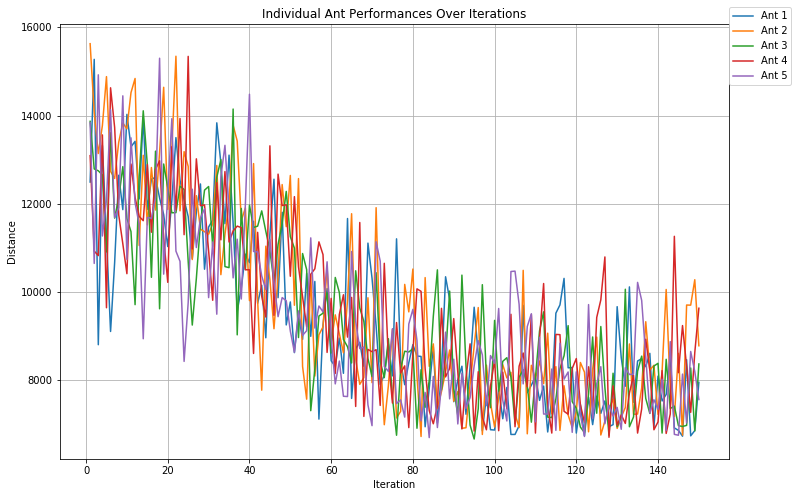

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Assuming the ACO class is already defined with the new tracking for individual ants
# Initialize the ACO algorithm with the necessary parameters
aco = ACO(distance_matrix=distance_matrix,  # The distance matrix is predefined
          num_ants=5,
          num_iterations=150,
          decay=0.1,
          alpha=1,
          beta=2.5)

# Start measuring time
start_time = time.time()

# Run the ACO algorithm
best_route, best_distance = aco.run()

# Measure the execution time
end_time = time.time()
duration = end_time - start_time

# Now print out the best route and distance information
print("Best route found:", best_route)
print("Total distance of the best route:", best_distance)
print(f"Execution time: {duration:.2f} seconds")

# Individual ant performances
individual_best = aco.individual_best  # Best distances for each ant
individual_worst = aco.individual_worst  # Worst distances for each ant
individual_avg = aco.individual_average  # Average distances for each ant

plt.figure(figsize=(12, 8))
for ant_index in range(aco.num_ants):
    plt.plot(np.arange(1, aco.num_iterations + 1), aco.ant_distance_history[ant_index, :], label=f'Ant {ant_index+1}')
plt.title('Individual Ant Performances Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Distance')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))  # Adjust legend location
plt.grid(True)
plt.show()